In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import numpy as np
import pandas as pd
import awkward as ak
import tensorflow as tf
from tensorflow import keras
import matplotlib
#matplotlib.use("Agg")
matplotlib.rcParams["figure.figsize"] = [6.4 / 1.3, 4.8 / 1.3]
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
from argparse import ArgumentParser
import mplhep as hep
import vector
import hist
from hist import Hist
from general import custom_objects, feat, table_to_numpy_visualization, load_normalization, SwitchLayer, HDF5File, MaxPassLayer, TitledModel
from model_bcls import make_model as make_model_b
from model_bcls import load_data as load_data_b
from model_tt import make_model, load_data as load_data_tt

In [20]:
a = 90

In [21]:
def get_normalization(table, exclude=None):
    offset = table.nanmean()
    scale =  table.nanstd()
    
    print(offset)
    print(scale)
    
    for column in ak.fields(offset):
        if exclude is not None and column in exclude:
            offset[column] = [0.0]
            scale[column] = [1.0]
        if scale[column][0] == 0:  # Avoid NaN after divison
            scale[column] = [1.0]
    return offset, scale

## Main

In [22]:
!ls /nfs/dust/cms/user/stafford/For_Emanuele/reconn/2907_nn_inputs

_TTbarDMJets_Dilepton_scalar_LO_Mchi_1_Mphi_100_TuneCP5_13TeV_madgraph_mcatnlo_pythia8
_TTbarDMJets_Dilepton_scalar_LO_Mchi_1_Mphi_150_TuneCP5_13TeV_madgraph_mcatnlo_pythia8
_TTbarDMJets_Dilepton_scalar_LO_Mchi_1_Mphi_200_TuneCP5_13TeV_madgraph_mcatnlo_pythia8
_TTbarDMJets_Dilepton_scalar_LO_Mchi_1_Mphi_250_TuneCP5_13TeV_madgraph_mcatnlo_pythia8
_TTbarDMJets_Dilepton_scalar_LO_Mchi_1_Mphi_300_TuneCP5_13TeV_madgraph_mcatnlo_pythia8
_TTbarDMJets_Dilepton_scalar_LO_Mchi_1_Mphi_350_TuneCP5_13TeV_madgraph_mcatnlo_pythia8
_TTbarDMJets_Dilepton_scalar_LO_Mchi_1_Mphi_400_TuneCP5_13TeV_madgraph_mcatnlo_pythia8
_TTbarDMJets_Dilepton_scalar_LO_Mchi_1_Mphi_450_TuneCP5_13TeV_madgraph_mcatnlo_pythia8
_TTbarDMJets_Dilepton_scalar_LO_Mchi_1_Mphi_500_TuneCP5_13TeV_madgraph_mcatnlo_pythia8
_TTbarDMJets_Dilepton_scalar_LO_Mchi_1_Mphi_50_TuneCP5_13TeV_madgraph_mcatnlo_pythia8
_TTbarDMJets_Dilepton_scalar_LO_Mchi_20_Mphi_100_TuneCP5_13TeV_madgraph_mcatnlo_pythia8
_TTbarDMJets_Dilepton_scalar_LO_Mchi_30_Mph

loading all possible datasets

In [23]:
def load_dataset(path):
    with HDF5File(path, "r") as f:
        data   = f["data"]
        offset = f["offset"]
        scale  = f["scale"]
        for field in data.fields:
            data[field] = data[field] * scale[field] + offset[field]
        return data

In [24]:
path = "/nfs/dust/cms/user/stafford/For_Emanuele/reconn/2907_nn_inputs/"

train_datasets = [path + f"_TTbarDMJets_Dilepton_scalar_LO_Mchi_1_Mphi_{i*50}_TuneCP5_13TeV_madgraph_mcatnlo_pythia8/traindata.hdf5" for i in range(1,11)]
train_datasets = train_datasets + [path + "TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/traindata.hdf5"]

valid_datasets = [path + f"_TTbarDMJets_Dilepton_scalar_LO_Mchi_1_Mphi_{i*50}_TuneCP5_13TeV_madgraph_mcatnlo_pythia8/validatedata.hdf5" for i in range(1,11)]
valid_datasets = valid_datasets + [path + "TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/validatedata.hdf5"]


In [25]:
train_data_list = [load_dataset(dataset) for dataset in train_datasets]   
train_weights = [data['weight'] for data in train_data_list]

valid_data_list = [load_dataset(dataset) for dataset in valid_datasets]
valid_weights = [data['weight'] for data in valid_data_list]

50 1106.9021990825368 64134


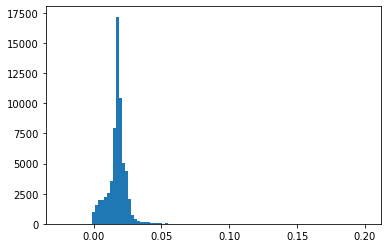

100 267.2784871708275 64936


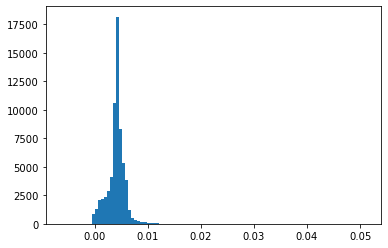

150 91.02200817236657 34966


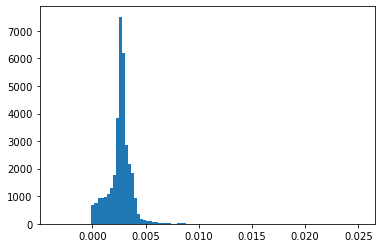

200 39.69079924825541 36114


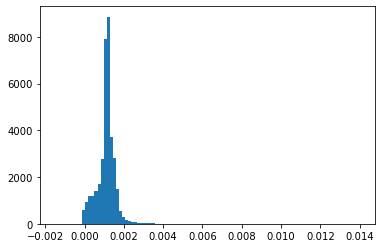

250 20.52302020890916 34213


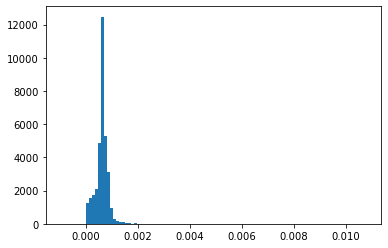

300 11.876001223407547 32134


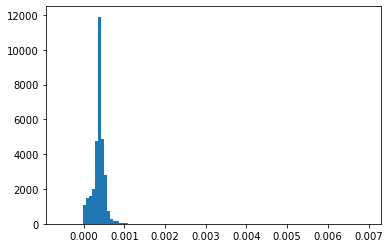

350 7.708356245503202 29712


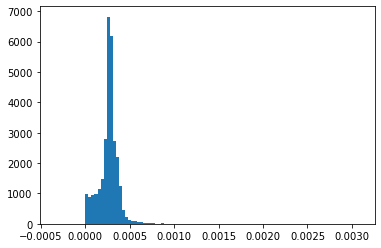

400 4.6343192107592355 28849


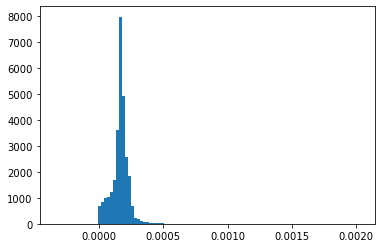

450 2.8903139951229475 28494


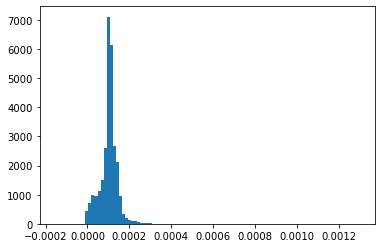

500 1.9734786998866058 26021


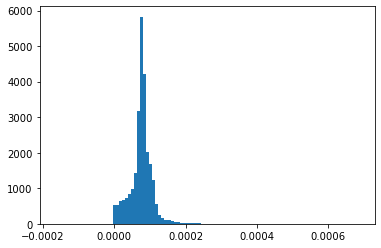

SM 48715.527516372575 700000


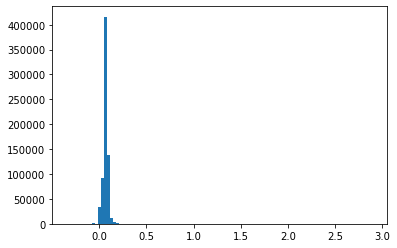

1554.498983257575 50270.02649963015


In [26]:
for i, weight in enumerate(train_weights):
    if i < 10:
        print((i+1)*50, sum(weight), len(weight))
    else:
        print('SM', sum(weight), len(weight))
    plt.hist(weight, bins=100)
    plt.show()

tot_DM_train = sum([sum(w) for w in train_weights[:-1]])
tot_SM_train = sum(train_weights[-1])
tot_train = tot_DM_train + tot_SM_train

tot_DM_valid = sum([sum(w) for w in valid_weights[:-1]])
tot_SM_valid = sum(valid_weights[-1])
tot_valid = tot_DM_valid + tot_SM_valid

print(tot_DM_train, tot_train)

In [27]:
# Normalize each DM dataset and the SM dataset
DM_sums_train = [sum(w) for w in train_weights]
for i in range(10):
    train_weights[i] = train_weights[i] / DM_sums_train[i]
train_weights[-1] = train_weights[-1] / sum(train_weights[-1])

tot_DM_train = sum([sum(w) for w in train_weights[:-1]])
tot_SM_train = sum(train_weights[-1])
tot_train = tot_DM_train + tot_SM_train

print(tot_DM_train, tot_train)

'''
DM_sums_valid = [sum(w) for w in valid_weights[:-1]]
for i in range(10):
    valid_weights[i] = valid_weights[i] / DM_sums_valid[i]
valid_weights[-1] = valid_weights[-1] / sum(valid_weights[-1])
'''
for i in range(10):
    valid_weights[i] = valid_weights[i] / DM_sums_train[i]
valid_weights[-1] = valid_weights[-1] / DM_sums_train[-1]

tot_DM_valid = sum([sum(w) for w in valid_weights[:-1]])
tot_SM_valid = sum(valid_weights[-1])
tot_valid = tot_DM_valid + tot_SM_valid

9.999999999999968 10.999999999999972


In [28]:
reweight_factor_DM = (a / 100) * .1
reweight_factor_SM = ((100 - a) / 100)

check_sum = 0
for i in range(10):
    train_data_list[i]["montecarlo_weight"] = train_data_list[i]["weight"]
    train_data_list[i]["weight"] = train_weights[i] * reweight_factor_DM
    check_sum+=sum(train_data_list[i]['weight'])
train_data_list[-1]["montecarlo_weight"] = train_data_list[-1]["weight"]
train_data_list[-1]["weight"] = train_weights[-1] * reweight_factor_SM

check_sum+=sum(train_data_list[-1]['weight'])
print(check_sum, sum(train_data_list[-1]['weight']))

check_sum_valid = 0

for i in range(10):
    valid_data_list[i]["montecarlo_weight"] = valid_data_list[i]["weight"]
    valid_data_list[i]["weight"] = valid_weights[i] * reweight_factor_DM
    check_sum_valid+=sum(valid_data_list[i]['weight'])
valid_data_list[-1]["montecarlo_weight"] = valid_data_list[-1]["weight"]
valid_data_list[-1]["weight"] = valid_weights[-1] * reweight_factor_SM

check_sum_valid+=sum(valid_data_list[-1]['weight'])
print(check_sum_valid, sum(valid_data_list[-1]['weight']))

0.9999999999999984 0.0999999999999992
0.4278540588716786 0.04283124688685058


In [29]:
missing_fields = ['gendmmed_t', 'gendmmed_x', 'gendmmed_y', 'gendmmed_z']
sm_length_train = len(train_data_list[-1]['weight'])
sm_length_valid = len(valid_data_list[-1]['weight'])

for field in missing_fields:
    train_data_list[-1][field] = np.full(sm_length_train, np.nan)
    valid_data_list[-1][field] = np.full(sm_length_valid, np.nan)


In [30]:
for i in range(10):
    train_data_list[i]["mediator_mass"] = np.full(len(train_data_list[i]["weight"]), (i+1) * 50)
    valid_data_list[i]["mediator_mass"] = np.full(len(valid_data_list[i]["weight"]), (i+1) * 50)
train_data_list[-1]["mediator_mass"] = np.full(sm_length_train, np.nan)
valid_data_list[-1]["mediator_mass"] = np.full(sm_length_valid, np.nan)

In [31]:
fields_train = train_data_list[0].fields
combined_train_data = {field: ak.concatenate([data[field] for data in train_data_list]) for field in fields_train}

fields_valid = valid_data_list[0].fields
combined_valid_data = {field: ak.concatenate([data[field] for data in valid_data_list]) for field in fields_valid}

In [32]:
combined_train_data

{'wplus_t': <Array [418, 248, 165, 265, ... 104, 82.7, 118] type='1079573 * float64'>,
 'wplus_z': <Array [364, 205, -143, ... -36.5, -22.5, 70.3] type='1079573 * float64'>,
 'genlephel_eta': <Array [0.713, 1.63, -0.117, ... -2.17, 0.449] type='1079573 * float64'>,
 'abot_z': <Array [117, -62.7, -17.6, ... 165, -9.87, 122] type='1079573 * ?float64'>,
 'met_pt': <Array [114, 133, 36.2, ... 49.5, 149, 39.2] type='1079573 * float64'>,
 'genalep_y': <Array [-46.8, -45.8, -16.3, ... 9.86, 24.7] type='1079573 * float64'>,
 'genbot_z': <Array [44.2, 179, -154, ... -124, -7.45] type='1079573 * float64'>,
 'genlep_y': <Array [7.29, 14.2, -24.1, ... 17.7, 51.3] type='1079573 * float64'>,
 'abot_eta': <Array [0.924, -0.938, -0.222, ... -0.24, 1.7] type='1079573 * ?float64'>,
 'wplus_y': <Array [-182, -89.7, -7.96, ... -3.77, 5.65] type='1079573 * float64'>,
 'lep_y': <Array [7.16, 14.4, -24.2, ... 18.2, 52.5] type='1079573 * float64'>,
 'wminus_phi': <Array [3.12, 1.9, 3.04, ... 1.7, 0.941, 1.67]

In [33]:
train_shuffled_indices = np.random.permutation(len(combined_train_data["weight"]))
shuffled_train_data =  ak.Array({key: combined_train_data[key][train_shuffled_indices] for key in combined_train_data})
shuffled_train_data = ak.with_name(shuffled_train_data, "Dataframe")

In [34]:
valid_shuffled_indices = np.random.permutation(len(combined_valid_data["weight"]))
shuffled_valid_data =  ak.Array({key: combined_valid_data[key][valid_shuffled_indices] for key in combined_valid_data})
shuffled_valid_data = ak.with_name(shuffled_valid_data, "Dataframe")

In [35]:
# Recompute normalization
exclude_fields = ["source", "weight", "jet_flav"]
train_offset, train_scale = get_normalization(shuffled_train_data, exclude=exclude_fields)

normalized_train_data = (shuffled_train_data - train_offset) / train_scale

valid_offset, valid_scale = get_normalization(shuffled_valid_data, exclude=exclude_fields)

#normalized_valid_data = (shuffled_valid_data - valid_offset) / valid_scale
normalized_valid_data = (shuffled_valid_data - train_offset) / train_scale

# Save combined dataset
combined_path = f"/nfs/dust/cms/user/coradine/DATA/DM_{int(a)}_SM_{int(100-a)}/traindata.hdf5"

directory = os.path.dirname(combined_path)

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)
    
with HDF5File(combined_path, "w") as f:
    # Save the combined normalized data
    f["data"] = normalized_train_data

    # Save the offset and scale
    f["offset"] = train_offset
    f["scale"] = train_scale

print(f"Combined dataset saved to {combined_path}")

[... montecarlo_weight: 0.0466, weight: 9.26e-07, mediator_mass: 232}]
[... montecarlo_weight: 0.0389, weight: 1.31e-06, mediator_mass: 146}]
[... montecarlo_weight: 0.0465, weight: 9.25e-07, mediator_mass: 232}]
[... montecarlo_weight: 0.0388, weight: 1.31e-06, mediator_mass: 146}]
Combined dataset saved to /nfs/dust/cms/user/coradine/DATA/DM_90_SM_10/traindata.hdf5


In [36]:
combined_valid_path = f"/nfs/dust/cms/user/coradine/DATA/DM_{int(a)}_SM_{int(100-a)}/validatedata.hdf5"
with HDF5File(combined_valid_path, "w") as f:
    # Save the combined normalized data
    f["data"] = normalized_valid_data

    # Save the offset and scale
    #f["offset"] = valid_offset
    #f["scale"] = valid_scale
    f["offset"] = train_offset
    f["scale"] = train_scale
print(f"Combined validation dataset saved to {combined_valid_path}")


Combined validation dataset saved to /nfs/dust/cms/user/coradine/DATA/DM_90_SM_10/validatedata.hdf5


In [37]:
!ls /nfs/dust/cms/user/coradine/DATA/

DM_10_SM_90  DM_30_SM_70  DM_50_SM_50  DM_70_SM_30  DM_90_SM_10
DM_20_SM_80  DM_40_SM_60  DM_60_SM_40  DM_80_SM_20
